<a href="https://colab.research.google.com/github/brendarocha1/ser-347/blob/main/Fluxo_de_Processamento_Dissertacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fluxo de Processamento de Imagens para Respostas Rápidas a Desastres**

> O código apresentado a seguir organiza diversas técnicas de Processamento Digital de Imagens (PDI) para a **análise rápida** de áreas atingidas por deslizamentos de terra e inundações regionais. A metodologia é voltada ao processamento de imagens dos satélites brasileiros CBERS-4, CBERS-4A e AMAZONIA-1.

Explicações detalhadas sobre o código podem ser encontradas em:

*   Rocha, B., Mioni, L., Oliveira, A., Costa, C. A., & Körting, T. S. (2023). Fluxo de Processamento de Imagens Para Respostas Rápidas à Desastres Naturais. In GEOINFO (pp. 460-465) [texto do link](http://mtc-m16c.sid.inpe.br/col/sid.inpe.br/mtc-m16c/2023/12.18.19.37/doc/thisInformationItemHomePage.html)


> **Este código faz parte da pesquisa de mestrado de Brenda Oliveira Rocha, realizada no Instituto Nacional de Pesquisas Espaciais (INPE) em 2023.**

Email para contato: brenda.rocha@inpe.br




In [ ]:
!pip install spectral -q
!pip install rasterio -q
!pip install GDAL
!pip install matplotlib
!pip install scikit-learn

# Importação de bibliotecas/métodos
from spectral import imshow
import tifffile as tif
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from osgeo import gdal, gdal_array
gdal.UseExceptions()
from sklearn.decomposition import PCA
from google.colab import files

In [15]:
# Função para normalizar os dados entre 0 e 255
def normalize_to_uint8(band):
    band_min, band_max = np.percentile(band, 2), np.percentile(band, 98)  # Cortando outliers
    band_scaled = (band - band_min) / (band_max - band_min)
    return np.clip(band_scaled * 255, 0, 255).astype(np.uint8)

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Leitura da imagem original
img_ori = tif.imread('/content/drive/MyDrive/inserir_caminho_da_imagem.tif')

# Obtenção de metadados
with rio.open('/content/drive/MyDrive/inserir_caminho_da_imagem.tif') as dataset:
    meta = dataset.profile

Valores mínimos por banda: [54, 41, 27, 47]
Percentis 1 por banda: [58.0, 45.0, 30.0, 54.0]


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


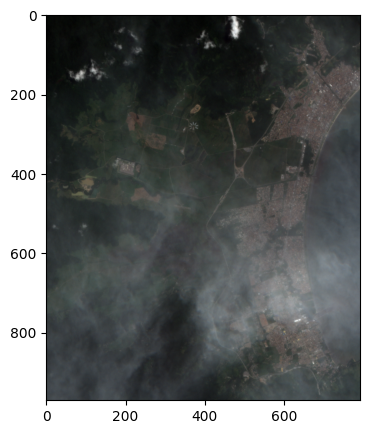

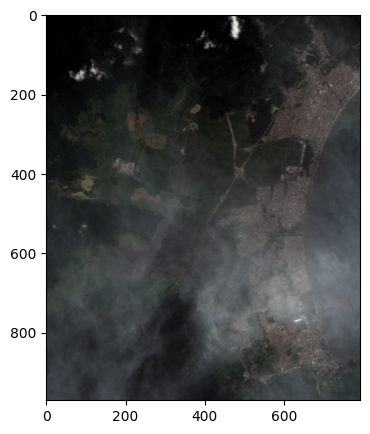

In [17]:
# Criando uma lista com os nomes das bandas corrigidas
l_arquivo = ['img_corrigida' + str(i + 1) for i in range(img_ori.shape[2])]

l_min = [img_ori[:,:,i].min() for i in range(img_ori.shape[2])]
l_per = [np.percentile(img_ori[:,:,i], 1) for i in range(img_ori.shape[2])]
print("Valores mínimos por banda:", l_min)
print("Percentis 1 por banda:", l_per)

# Correção das bandas pelo método Dark Object Subtraction
for i in range(img_ori.shape[2]):
    l_arquivo[i] = np.where((img_ori[:,:,i] - l_per[i]) > 0, img_ori[:,:,i] - l_per[i], 1)

# Empilhamento das bandas espectrais corrigidas
stack_img_corr = np.dstack(l_arquivo)

# Visualização de uma composição colorida (RGB) da imagem original
imshow(img_ori, (2, 1, 0), figsize=(8, 5))

# Visualização da imagem corrigida
imshow(stack_img_corr, (2, 1, 0), figsize=(8, 5))

# Gravar a imagem corrigida em disco (normalizando corretamente)
stack_WPM = np.moveaxis(stack_img_corr, -1, 0)

# Normalizando cada banda individualmente entre 0 e 255
for i in range(stack_WPM.shape[0]):
    stack_WPM[i] = normalize_to_uint8(stack_WPM[i])

meta.update({'count': stack_WPM.shape[0], 'dtype': 'uint8'})  # Atualizando metadados

with rio.open('sao_sebastiao_corrigida.tiff', 'w', **meta) as dst:
    dst.write(stack_WPM)  # Salvando como uint8 (8-bit)


Text(0.5, 1.0, 'Imagem corrigida WPM/CBERS-4A')

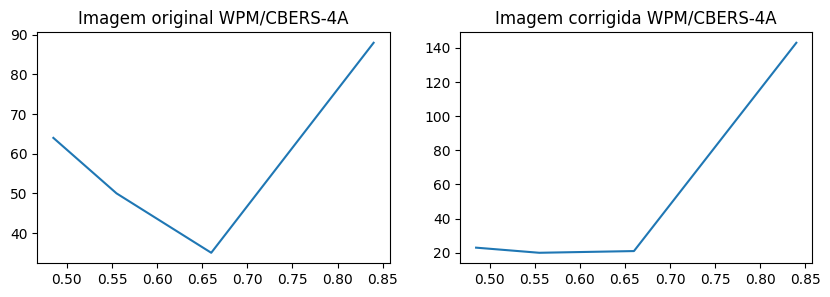

In [18]:
# Comparação espectral entre a imagem original e a imagem corrida de uma localização específica (pixel na coordenada [261, 426])
plt.rcParams['figure.figsize'] = (10,3)
x= 0.485, 0.555, 0.66, 0.84
fig, ax= plt.subplots(1,2)
ax[0].plot(x, img_ori [261, 426,:])
ax[0].set_title('Imagem original WPM/CBERS-4A')
ax[1].plot(x, stack_img_corr [261, 426,:])
ax[1].set_title('Imagem corrigida WPM/CBERS-4A')

<ipython-input-19-0809865fda40>:8: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir_band - red_band) / (nir_band + red_band)
<ipython-input-19-0809865fda40>:18: RuntimeWarning: divide by zero encountered in divide
  evi = G * ((nir_band - red_band) / (nir_band + C1 * red_band - C2 * blue_band + L))
<ipython-input-19-0809865fda40>:21: RuntimeWarning: invalid value encountered in divide
  ndwi = (green_band - nir_band) / (green_band + nir_band)


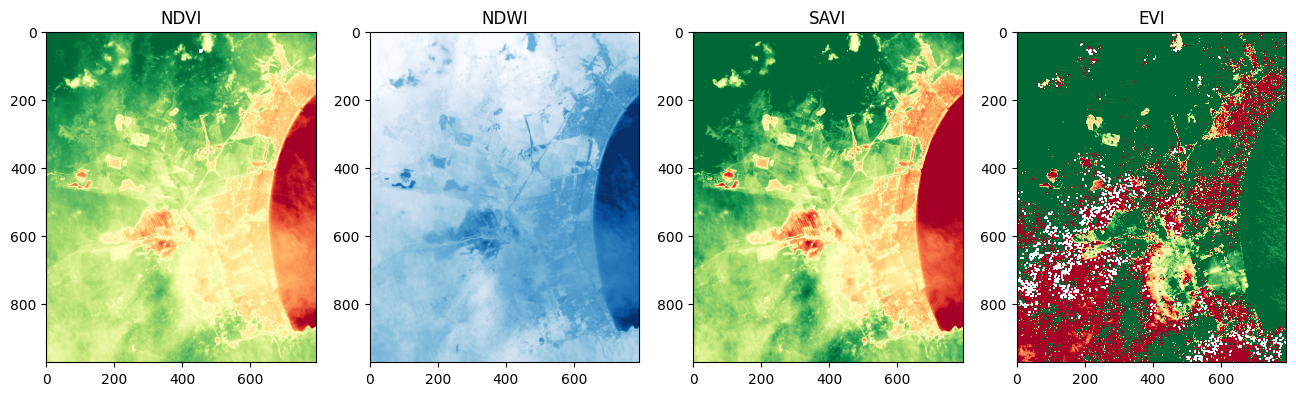

In [19]:
# Calcular índices espectrais a partir das bandas corrigidas
blue_band = stack_WPM[0] # BLUE
green_band = stack_WPM[1] # GREEN
red_band = stack_WPM[2]  # Red
nir_band = stack_WPM[3]  # NIR

# NDVI (Normalized Difference Vegetation Index)
ndvi = (nir_band - red_band) / (nir_band + red_band)

# SAVI (Soil Adjusted Vegetation Index)
L = 0.5  # Fator de ajuste do solo, pode ser alterado conforme necessário
savi = ((1 + L) * (nir_band - red_band)) / (nir_band + red_band + L)

# EVI (Enhanced Vegetation Index)
G = 2.5  # Ganho, pode ser alterado conforme necessário
C1 = 6.0  # Coeficiente do termo do canope, pode ser alterado conforme necessário
C2 = 7.5  # Coeficiente do termo do solo, pode ser alterado conforme necessário
evi = G * ((nir_band - red_band) / (nir_band + C1 * red_band - C2 * blue_band + L))

# NDWI (Normalized Difference Water Index)
ndwi = (green_band - nir_band) / (green_band + nir_band)

# Visualizar os índices espectrais
plt.figure(figsize=(16, 10))
plt.subplot(141)
plt.title("NDVI")
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1.0, vmax=1.0);
plt.subplot(143)
plt.title("SAVI")
plt.imshow(savi, cmap='RdYlGn', vmin=-1.0, vmax=1.0);
plt.subplot(144)
plt.title("EVI")
plt.imshow(evi, cmap='RdYlGn', vmin=-1.0, vmax=1.0);
plt.subplot(142)
plt.title("NDWI")
plt.imshow(ndwi, cmap='Blues', vmin=-1.0, vmax=1.0);

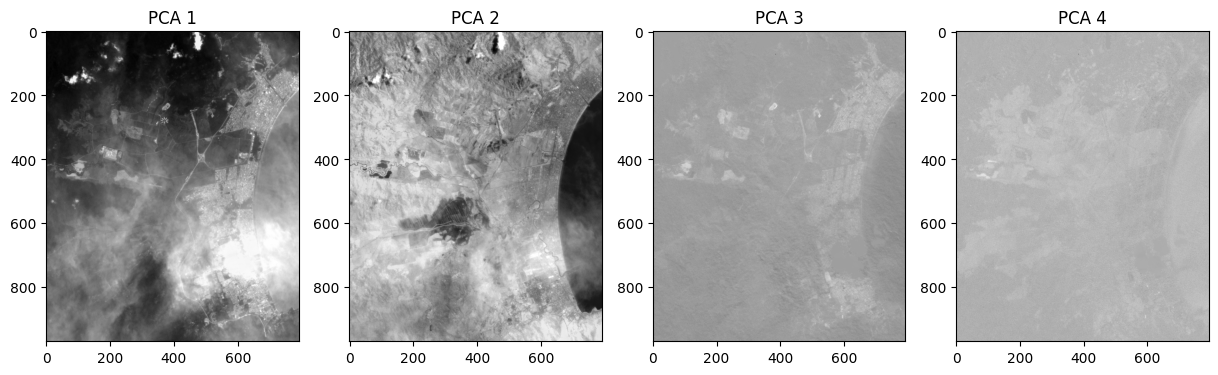

In [20]:
# Implementação da Principal Component Analysis (PCA)
num_bandas, num_linhas, num_colunas = stack_WPM.shape
bandas_reshaped = stack_WPM.reshape(num_bandas, num_linhas * num_colunas).T
pca = PCA(n_components=4)
bandas_pca = pca.fit_transform(bandas_reshaped)
bandas_pca = bandas_pca.T.reshape(4, num_linhas, num_colunas)

# Visualizar as principais componentes (PCs)
fig, axes = plt.subplots(1, 4, figsize=(15, 10))
for i in range(4):
    axes[i].imshow(bandas_pca[i], cmap='gray')
    axes[i].set_title(f'PCA {i + 1}')
plt.show()

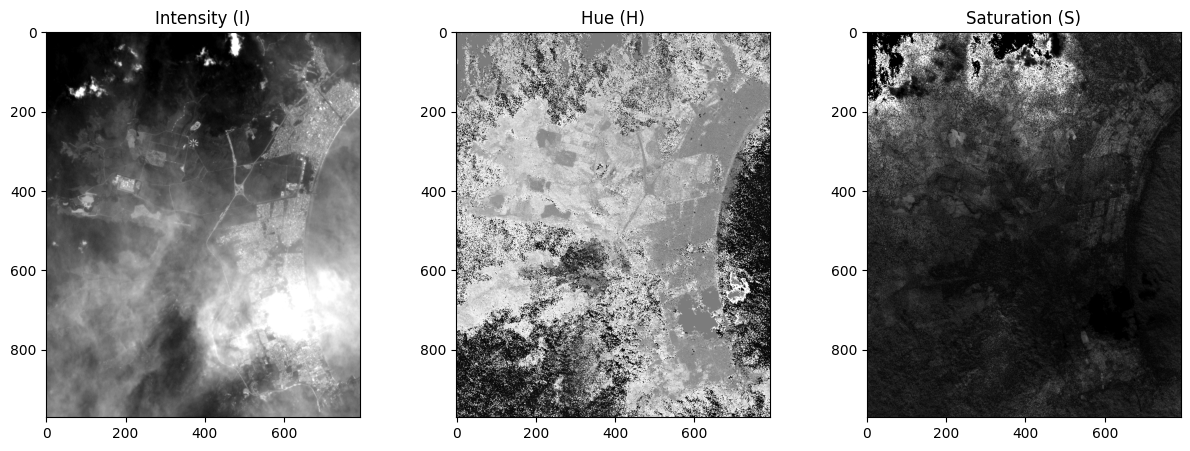

In [21]:
# Transformação de cores RGB-IHS
I = (red_band + green_band + blue_band) / 3.0
H = 0.5 * np.arctan2(np.sqrt(3) * (green_band - blue_band), 2 * red_band - green_band - blue_band)
num = 2 * (red_band - green_band) ** 2 + (red_band - blue_band) * (green_band - blue_band)
den = red_band ** 2 + green_band ** 2 + blue_band ** 2 + 1e-8
S = np.sqrt(num / den)

# Normalizar as bandas IHS e garantir compatibilidade com SIG
I_norm = normalize_to_uint8(I)
H_norm = normalize_to_uint8(H)
S_norm = normalize_to_uint8(S)

# Visualizar as bandas transformadas IHS
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(I_norm, cmap='gray')
axes[0].set_title('Intensity (I)')
axes[1].imshow(H_norm, cmap='gray')
axes[1].set_title('Hue (H)')
axes[2].imshow(S_norm, cmap='gray')
axes[2].set_title('Saturation (S)')
plt.show()

In [22]:
# Normalização das bandas PCA
pc1_norm = (bandas_pca[0] - np.min(bandas_pca[0])) / (np.max(bandas_pca[0]) - np.min(bandas_pca[0]))
pc2_norm = (bandas_pca[1] - np.min(bandas_pca[1])) / (np.max(bandas_pca[1]) - np.min(bandas_pca[1]))
pc3_norm = (bandas_pca[2] - np.min(bandas_pca[2])) / (np.max(bandas_pca[2]) - np.min(bandas_pca[2]))
pc4_norm = (bandas_pca[3] - np.min(bandas_pca[3])) / (np.max(bandas_pca[3]) - np.min(bandas_pca[3]))

# Normalizar a banda NIR e os índices
nir_norm = (nir_band - np.min(nir_band)) / (np.max(nir_band) - np.min(nir_band))
ndvi_norm = (nir_band - np.min(nir_band)) / (np.max(nir_band) - np.min(nir_band))
ndwi_norm = (ndwi - np.min(ndwi)) / (np.max(ndwi) - np.min(ndwi))
savi_norm = (savi - np.min(savi)) / (np.max(savi) - np.min(savi))
evi_norm = (evi - np.min(evi)) / (np.max(evi) - np.min(evi))

<ipython-input-22-361679bb54d6>:12: RuntimeWarning: invalid value encountered in subtract
  evi_norm = (evi - np.min(evi)) / (np.max(evi) - np.min(evi))
<ipython-input-22-361679bb54d6>:12: RuntimeWarning: invalid value encountered in divide
  evi_norm = (evi - np.min(evi)) / (np.max(evi) - np.min(evi))


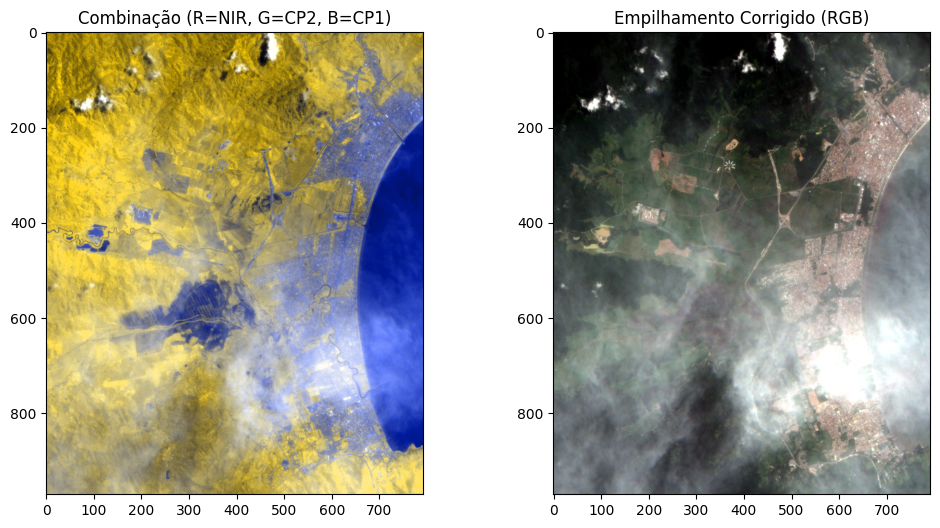

In [23]:
# Combinação no espaço de cores RGB
R = nir_norm
G = pc2_norm
B = pc1_norm

# Empilhar as componentes em um único array RGB
rgb_combined = np.stack([R, G, B], axis=-1)

# Normalização e empilhamento das bandas corrigidas RGB (com valores entre 0 e 1)
rgb_bands_corrigidas = np.moveaxis(stack_img_corr[:, :, [2, 1, 0]], 2, 0)
rgb_bands_corrigidas_norm = rgb_bands_corrigidas / np.max(rgb_bands_corrigidas)

# Visualizar as composições RGB
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(rgb_combined)
axes[0].set_title('Combinação (R=NIR, G=CP2, B=CP1)')
axes[1].imshow(np.moveaxis(rgb_bands_corrigidas_norm, 0, -1))
axes[1].set_title('Empilhamento Corrigido (RGB)')
plt.show()


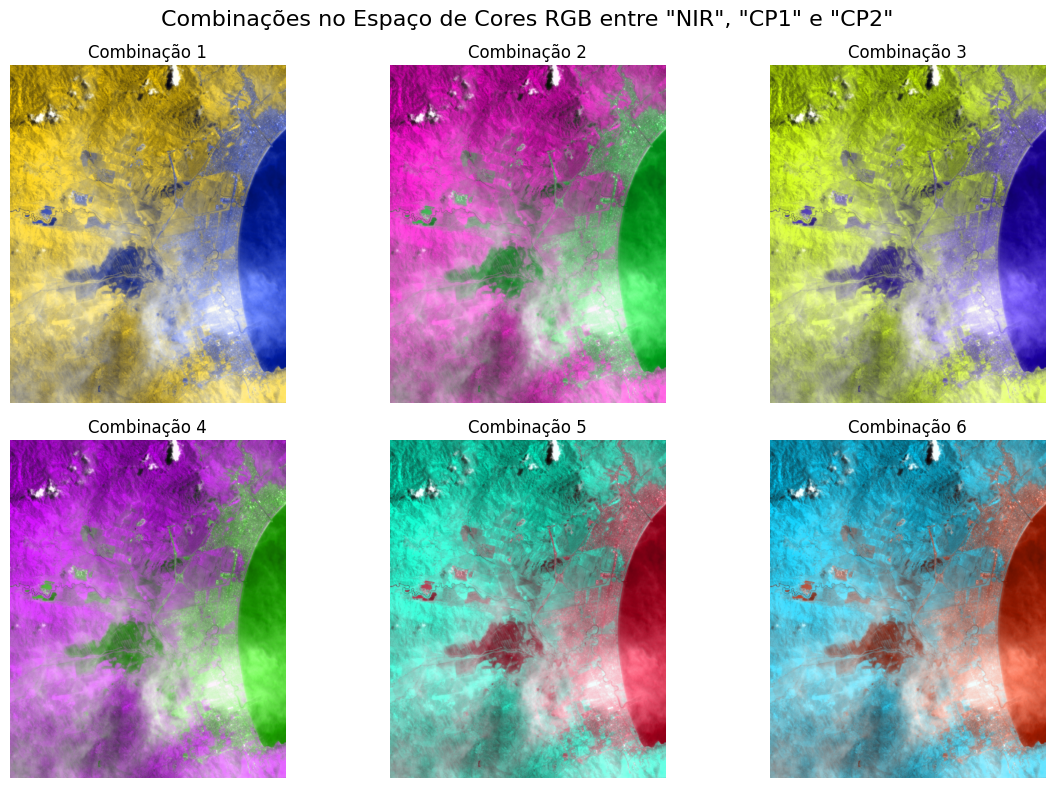

In [24]:
# Criar todas as combinações possíveis das três bandas
combinations = [(R, G, B), (R, B, G), (G, R, B), (G, B, R), (B, R, G), (B, G, R)]

# Configurar a figura para exibir as combinações
plt.figure(figsize=(12, 8))
plt.suptitle('Combinações no Espaço de Cores RGB entre "NIR", "CP1" e "CP2"', fontsize=16)

# Exibir cada combinação em uma grade
for i, combination in enumerate(combinations):
    rgb_comb = np.stack(combination, axis=-1)

    plt.subplot(2, 3, i + 1)
    plt.imshow(rgb_comb)
    plt.title(f'Combinação {i + 1}')
    plt.axis('off')

# Ajustar o layout e exibir a figura
plt.tight_layout()
plt.show()

# Salvar as composições RGB como TIFF
meta.update({'count': 3, 'dtype': 'float32'})  # 3 bandas e formato float32 para as imagens normais

# Salvar RGB combinado (R=NIR, G=CP2, B=CP1)
with rio.open('rgb_combinado_corrigido.tiff', 'w', **meta) as dst:
    dst.write(np.moveaxis(rgb_combined, -1, 0))
